# Import Library

cv2 (OpenCV): for computer vision and image processing

matplotlib.pyplot as plt: ploting & show image

numpy as np: for efficient numerical computation

In [22]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Declre Reuseable Function

show_image: Displays an image using matplotlib, automatically choosing a grayscale colormap if the image is 2D.

AdaptiveThresh: Applies adaptive thresholding to a grayscale image, which helps to segment out objects from the background by dynamically adjusting the threshold value based on the local intensity of the image.

get_rect: Calculates the bounding rectangle of a set of points, returning the top-left and bottom-right coordinates of the rectangle

In [23]:
def show_image(image, figsize=(7,7), cmap=None):
    cmap = cmap if len(image.shape)==3 else 'gray'
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap=cmap)
    plt.show()

def AdaptiveThresh(gray):
    blur = cv2.medianBlur(gray, 5)
    adapt_type = cv2.ADAPTIVE_THRESH_GAUSSIAN_C
    thresh_type = cv2.THRESH_BINARY_INV
    return cv2.adaptiveThreshold(blur, 255, adapt_type, thresh_type, 11, 2)

def get_rect(pts):
    xmin = pts[:,0,1].min()
    ymin = pts[:,0,0].min()
    xmax = pts[:,0,1].max()
    ymax = pts[:,0,0].max()
    return (ymin,xmin), (ymax,xmax)

# Load Image

reads an image file specified by the image_name variable and converts it to grayscale. The cv2.cvtColor function is used to convert the image from the BGR color space to RGB and then to grayscale. The resulting grayscale image is then displayed using the show_image function.

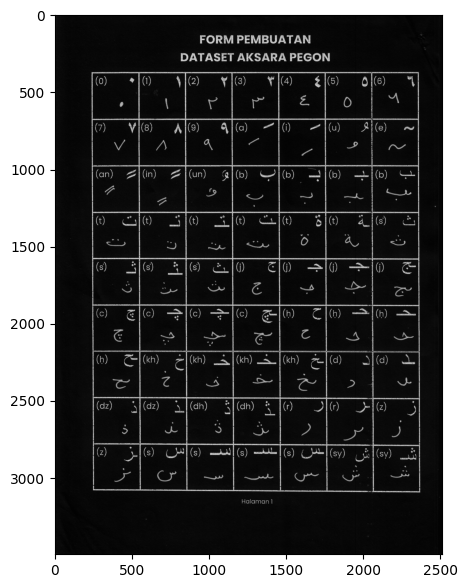

In [24]:
image_name = os.path.join('..', 'Documents', 'Hand-Writing-5', '1.jpg')
image_original = cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2RGB)
image_gray = 255-cv2.cvtColor(image_original, cv2.COLOR_RGB2GRAY)
show_image(image_gray)

# Morphology Dilation

applies a morphological dilation operation to the image_gray using a 3x3 kernel, then inverts the result.

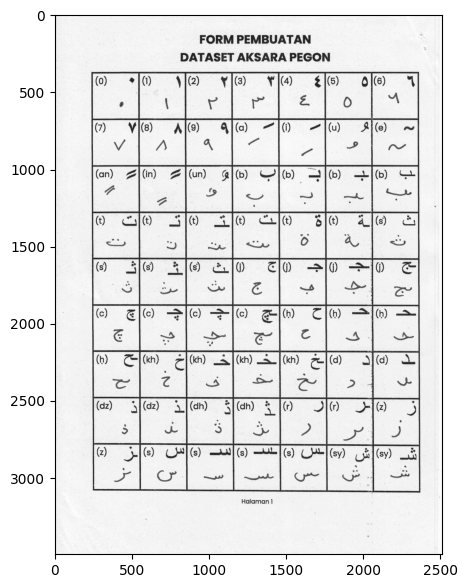

In [25]:
kernel = np.ones((3,3),np.uint8)
d = 255-cv2.dilate(image_gray,kernel,iterations = 1)
show_image(d) 

# Binary Threshold

converts the input image to a binary image by applying a threshold value that is calculated adaptively for each pixel based on the surrounding pixels.

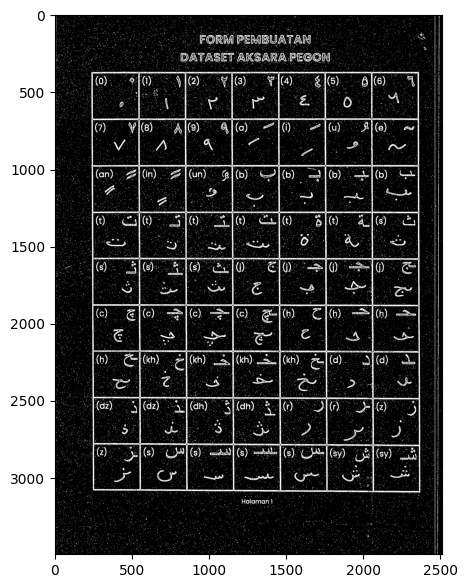

In [26]:
e = AdaptiveThresh(d)
show_image(e)

# Prepare Dontour Detection

Dilation: Expand the white areas in the binary image e using the kernel (a 3x3 matrix of ones) to fill in small gaps.

Median Blur: Apply a median blur with a kernel size of 11 to the dilated image m to reduce noise and smooth out the image.

Dilation (again): Repeat the dilation operation to further expand the white areas.

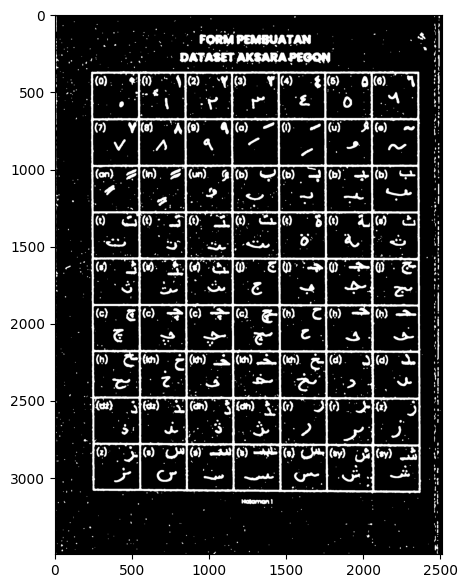

In [27]:
m = cv2.dilate(e,kernel,iterations = 1)
m = cv2.medianBlur(m,11)
m = cv2.dilate(m,kernel,iterations = 1)
show_image(m)

# Contour Detection

find contour & draw green rectangle

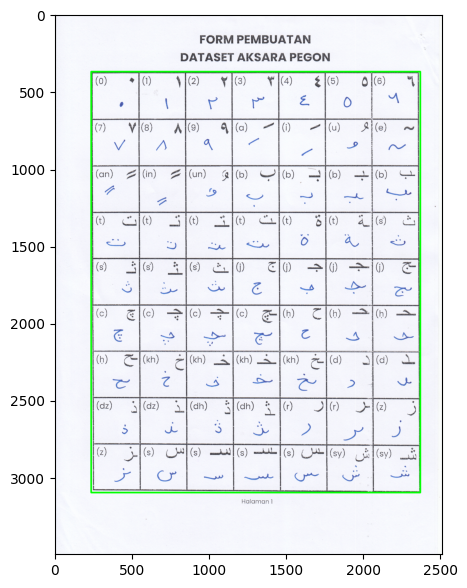

In [28]:
contours, hierarchy = cv2.findContours(m, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

total_area = np.prod(image_gray.shape)
max_area = 0
for cnt in contours:
    perimeter = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.03 * perimeter, True)
    area = cv2.contourArea(approx)

    if (len(approx) == 4 and cv2.isContourConvex(approx) and max_area<area<total_area):
        max_area = cv2.contourArea(approx)
        quad_polygon = approx

img1 = image_original.copy()
img2 = image_original.copy()

cv2.polylines(img1,[quad_polygon],True,(0,255,0),10)
tl, br = get_rect(quad_polygon)

cv2.rectangle(img2, tl, br, (0,255,0), 10)
show_image(img2)

# Contour Correction

correct the perspective of an image, such as a scanned document or a photo taken at an angle, to make it appear as if it were taken directly from above.

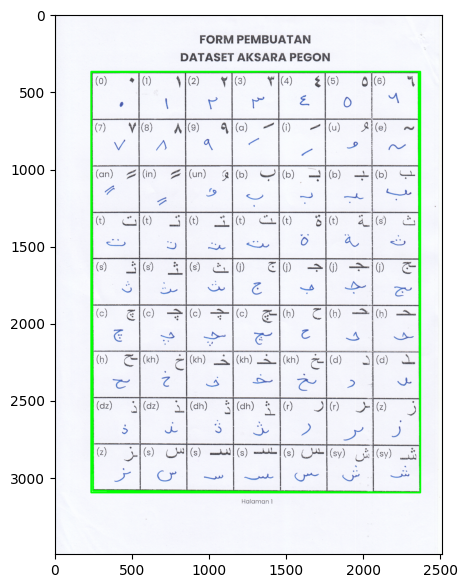

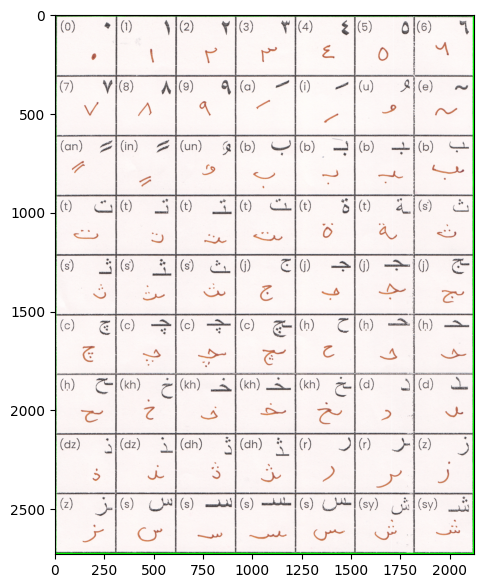

In [29]:
cv2.polylines(img2, [quad_polygon], True, (0, 255, 0), 10)
show_image(img2)

pts = quad_polygon.reshape(4, 2)
rect = np.zeros((4, 2), dtype="float32")

s = pts.sum(axis=1)
rect[0] = pts[np.argmin(s)]
rect[2] = pts[np.argmax(s)]

diff = np.diff(pts, axis=1)
rect[1] = pts[np.argmin(diff)]
rect[3] = pts[np.argmax(diff)]

(tl, tr, br, bl) = rect

widthA = np.linalg.norm(br - bl)
widthB = np.linalg.norm(tr - tl)
maxWidth = max(int(widthA), int(widthB))

heightA = np.linalg.norm(tr - br)
heightB = np.linalg.norm(tl - bl)
maxHeight = max(int(heightA), int(heightB))

dst = np.array([
    [0, 0],
    [maxWidth - 1, 0],
    [maxWidth - 1, maxHeight - 1],
    [0, maxHeight - 1]
], dtype="float32")

M = cv2.getPerspectiveTransform(rect, dst)
warped = cv2.warpPerspective(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB), M, (maxWidth, maxHeight))

show_image(warped)

# Get Final Data

takes an image, divides it into a grid of tiles, and then processes each tile. The processing involves cropping a smaller region of interest, converting it to grayscale, applying binary thresholding, inverting the binary image, and resizing it to a smaller size. Finally, all the processed tiles are displayed in a single figure.

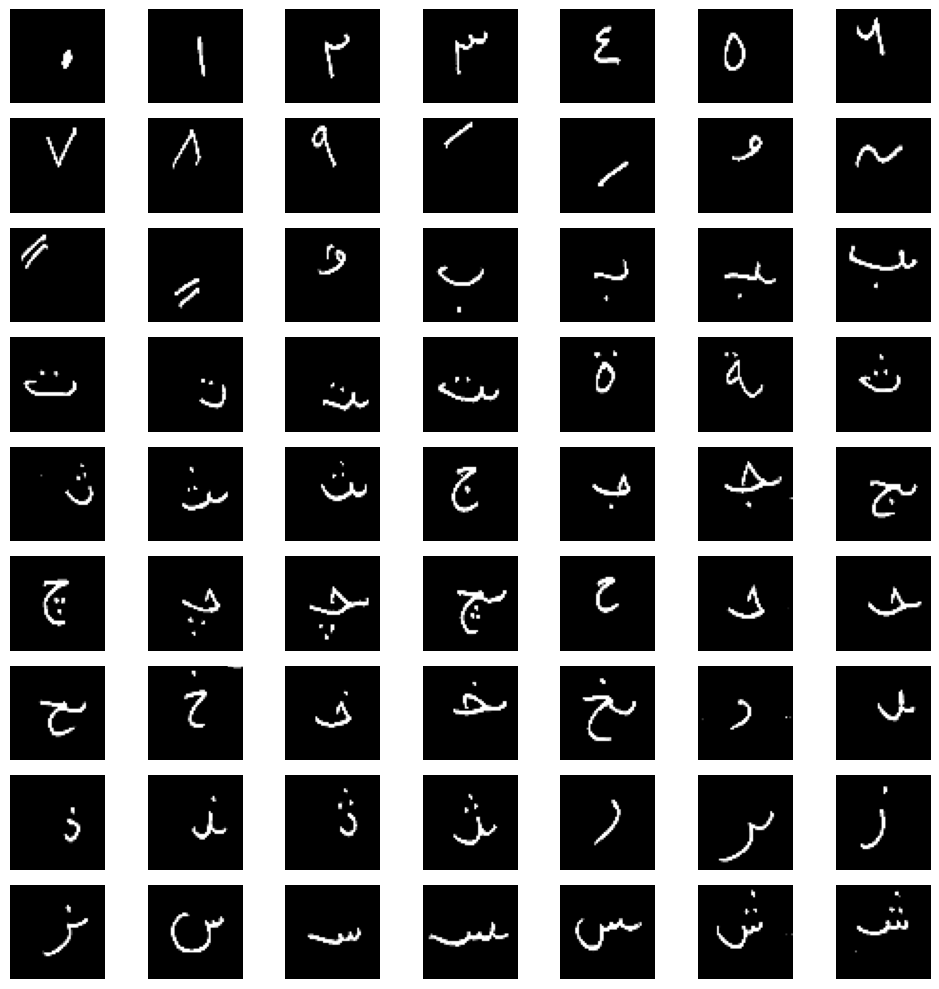

In [30]:
image = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)

rows = 9
cols = 7

height, width, _ = image.shape

tile_height = height // rows
tile_width = width // cols

fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i in range(rows):
    for j in range(cols):
        start_x = j * tile_width
        start_y = i * tile_height
        end_x = (j + 1) * tile_width
        end_y = (i + 1) * tile_height

        sub_image = image[start_y +120:end_y -15, start_x +60:end_x -15]
        sub_image_gray = cv2.cvtColor(sub_image, cv2.COLOR_BGR2GRAY)
        sub_image_binary = cv2.threshold(sub_image_gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        sub_image_binary_inv = 255 - sub_image_binary
        final = cv2.resize(sub_image_binary_inv, (50, 50))

        axes[i, j].imshow(final, cmap='gray')
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()
